In [ ]:
import glob
import numpy as np
import os
import h5py
import time
import datetime
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, chi2, uniform, poisson, ncx2
import getpass
os.system("echo %s| kinit" %getpass.getpass())

In [18]:


def Build_Data1D_Expo(scale, N_ref, N_Data, seed):
    """
    Build_Data1D_Expo generates a reference sample and a data sample distributed according to an exponential distribution:
    x ~ 1/scale * exp(-x/scale)
    Inputs:
    - scale:         parameter of the exponential distribution (float)
    - N_ref, N_Data: size of the reference and the data samples (int)
    - seed:          numpy random seed for the initialization (int)
    """
    np.random.seed(seed)
    feature = np.random.exponential(scale=scale, size=(N_ref+N_Data, 1))
    feature_REF  = feature[:N_ref, :]
    feature_DATA = feature[N_ref:, :]
    target_REF   = np.zeros(N_ref)
    target_DATA  = np.ones(N_Data)
   
    return feature_REF, feature_DATA, target_REF, target_DATA


def Apply_nu(DATA, nu):
    """
    Apply_nu modifies the data sample applying the effects of a nuisance parameter on the scale of the exponential distribution:
    x --> x' = nu * x

    Inputs:
    - DATA: data sample (numpy array shape:(N, 1))
    - nu: nuisance effect
    """
    DATA_new = nu*np.copy(DATA)
    return DATA_new

  
def Compute_correction_Expo1D_ExpoNu(fileIN, N_ref, N_Data, 
                                      scale_REF, scale_DATA, scale_star, sigma,
                                      t_corrected_list, t_list, Delta1_list, 
                                      Delta2_list, Delta_list, mean_list, nu0_list, nubest_list,
                                      Pois=False, verbose=False):
  
    """
    Compute_correction_Expo1D_ExpoNu reads the NN output (t= -2*Loss_final) from fileIN; 
    computes the correction terms Delta1 and Delta2 and applies them to t (t_corrected = t - (Delta1 + Delta2) ).
    Parametrization chosen for the exponential distribution affected by a scale nuisance:

    x ~ 1/exp(nu) * exp(-x/exp(nu))

    Inputs:
    - fileIN: file storing the NN output (.txt)
    - N_ref: size of the reference sample (int)
    - N_Data: median size of the data sample, poissonian distributed (int)
    - scale_REF: exp(nu_REF)
    - scale_DATA: exp(nu_DATA)
    - scale_star: exp(nu_star)
    - sigma: nu_DATA ~ Norm(nu_star, sigma)
    - t_list: list to which t for fileIN is appended
    - t_corrected_list: list to which t_corrected for fileIN is appended
    - Delta_list: list to which Delta for fileIN output correction is appended
    - Delta1_list: list to which Delta1 for fileIN output correction is appended
    - Delta2_list: list to which Delta2 for fileIN output correction is appended
    - nubest_list: list to which nu_best for fileIN output correction is appended
    - nu0_list: list to which nu0 genrated according to Norm(nu_star, sigma) is appended
    - mean_list: list to which the sample mean is appended
    - Pois: True if the size of the data sample has to be generated according to Poissonian(N_Data)
    - verbose: True to print the outputs
    """
    
    # read t
    f = open(fileIN)
    lines = f.readlines()
    if len(lines)==0:
        print("No t collected")
        return t_corrected_list, nubest_list, t_list, Delta1_list, Delta2_list, Delta_list, mean_list, nu0_list
    t = float(lines[0])
    t_list = np.append(t_list, t)
    f.close()
    
    # seed
    seed = fileIN.split("seed",1)[1] 
    seed = int(seed.split("_",1)[0])
    np.random.seed(seed)
    
    # Pois(N_Data)
    if Pois:
        N_Data_P = np.random.poisson(lam=N_Data, size=1)
        N_Data_p = N_Data_P[0]
    else:
        N_Data_p = N_Data
    
    # DATA
    feature_REF, feature_DATA, target_REF, target_DATA = Build_Data1D_Expo(1., N_ref, N_Data_p, seed)
    feature_REF  = Apply_nu(feature_REF, scale_REF)
    feature_DATA = Apply_nu(feature_DATA, scale_DATA)

    # Maximum
    Deltas  = np.array([])
    Deltas1 = np.array([])
    Deltas2 = np.array([])

    # list to be scanned to find the nu best fit
    scale_list = np.linspace(scale_star-0.1, scale_star+0.1, 1000)
    
    # reinitialize the random seed so that the correction is not determined by the seed which generates the samples (which is fixed)
    seed = datetime.datetime.now().microsecond+datetime.datetime.now().second+datetime.datetime.now().minute
    np.random.seed(seed)
    
    # generate nu0 ~ Norm(nu_star, sigma) (value of nu which is derived by auxiliary measurements)
    nu_star = np.log(scale_star)
    nu_REF  = np.log(scale_REF)
    nu0     = np.random.normal(loc=nu_star, scale=sigma, size=1)
    nu0     = nu0[0]
    
    # search the maximum
    for sc in scale_list:
        nu = np.log(sc)
        
        L_aux0  = norm.pdf(nu0,    loc=nu0, scale=sigma)
        L_aux1  = norm.pdf(nu,     loc=nu0, scale=sigma)
        L_aux2  = norm.pdf(nu_REF, loc=nu0, scale=sigma)
        
        sum_log = -feature_DATA.shape[0]*np.log(sc*1./scale_REF) + (1./scale_REF-1./sc)*np.sum(feature_DATA[:, 0])
        
        d1 =  2*(sum_log + np.log(L_aux1/L_aux2))
        d2 = -2*np.log(L_aux0/L_aux2)
        d  =  2*(sum_log + np.log(L_aux1/L_aux0))
        
        Deltas  = np.append(Deltas , d)
        Deltas1 = np.append(Deltas1, d1)
        Deltas2 = np.append(Deltas2, d2)
        
    #######################################################    
    nubest      = np.log(scale_list[np.argmax(Deltas)])
    D           = Deltas[np.argmax(Deltas)] 
    D1          = Deltas1[np.argmax(Deltas)]
    D2          = Deltas2[np.argmax(Deltas)]
    t_corrected = t - D
    
    t_corrected_list = np.append(t_corrected_list, t_corrected)
    nubest_list      = np.append(nubest_list, nubest)
    mean_list        = np.append(mean_list, np.mean(feature_DATA[:, 0]))
    nu0_list         = np.append(nu0_list, nu0)
    Delta_list       = np.append(Delta_list,  D )
    Delta1_list      = np.append(Delta1_list, D1)
    Delta2_list      = np.append(Delta2_list, D2)
    
    # Print results:
    if verbose:
    	print('N DATA:         %i'%(N_Data_p)) 
        print('REF  scale:    %f'%(scale_REF)) 
        print('DATA scale:    %f'%(scale_DATA)) 
        print('DATA mean:     %f'%(np.mean(feature_DATA[:, 0])))
        print('Generated nu0: %f'%(nu0)) 
        print('Best nu:       %f'%(nubest)) 

        print('Correction TOT: %s'%(D))
        print('Correction   1: %s'%(D1))
        print('Correction   2: %s'%(D2))
        print('t             : %s'%(t))
        print('Corrected t   : %s'%(t_corrected))
    return t_corrected_list, t_list, Delta1_list, Delta2_list, Delta_list, mean_list, nu0_list, nubest_list 

###########################################################################################
# PLOTTING FUNCTIONS and P-VALUE evaluation for the compatibility with target distributions

def Delta_hist(Delta1, Delta2, scale_REF, scale_star, sigma, df1=1, df2=1, bins1=10, bins2=10, 
               plot=True, verbose=False):
    
    plt.subplots(1, 2, figsize=(15, 6))
    
    # Delta1 hist
    plt.subplot(1, 2, 1)
    xmin = np.min(Delta1)
    xmax = np.max(Delta1)
    if xmax<5: xmax = 5
    bins = bins1
    df   = df1
    rv   = chi2(df)
    xrv  = chi2.rvs(df, size=10000)
    x    = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    
    #expected counts
    a = []
    for i in range(bins1):
        a_i = chi2.cdf(xmin+(i+1)*(xmax-xmin)*1./bins1, df1) - chi2.cdf(xmin+i*(xmax-xmin)*1./bins1, df1)
        a.append(a_i)
        
    h = plt.hist(Delta1, weights=np.ones_like(Delta1)*1./Delta1.shape[0], 
                 alpha=0.5, color='orange',
                 range=(xmin, xmax), bins=bins)
    chi_sq1 = np.sum((h[0]-a)**2*1./a)*Delta1.shape[0]
    pval_1  = 1.-chi2.cdf(chi_sq1, bins1-1)
    plt.hist(Delta1, weights=np.ones_like(Delta1)*1./Delta1.shape[0], 
             color='orange', histtype='step', lw=2, label='p-value: %s'%(str(np.around(pval_1, 4))),
             range=(xmin, xmax), bins=bins)
    plt.hist(xrv, weights=np.ones_like(xrv)*1./xrv.shape[0],
             color='dodgerblue', histtype='step',
             label=r'$\chi^2(%s)$ pdf'%(str(df)),
             range=(xmin, xmax), bins=bins, lw=2,
            )
    
    plt.errorbar(x, h[0], yerr=np.sqrt(h[0])*1./np.sqrt(len(Delta1)), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.xlabel(r'$\Delta_{1}$', fontsize=16)
    plt.legend(fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    
    # -Delta2 hist
    plt.subplot(1, 2, 2)
    xmin = np.min(-Delta2)
    xmax = np.max(-Delta2)
    if xmax<5: xmax = 5
    bins = bins2
    df   = df2
    rv   = chi2(df)
    x    = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    
    # expected counts
    a = []
    for i in range(bins2):
        a_i = chi2.cdf(xmin+(i+1)*(xmax-xmin)*1./bins2, df2) - chi2.cdf(xmin+i*(xmax-xmin)*1./bins2, df2)
        a.append(a_i)
    h = plt.hist(-Delta2, weights=np.ones_like(Delta2)*1./Delta2.shape[0], 
                 alpha=0.5, color='orange',
                 range=(xmin, xmax), bins=bins)
    chi_sq2 = np.sum((h[0]-a)**2*1./a)*Delta2.shape[0]
    pval_2  = 1.-chi2.cdf(chi_sq2, bins2-1)
    plt.hist(-Delta2, weights=np.ones_like(Delta2)*1./Delta2.shape[0], 
             color='orange', histtype='step', lw=2, label='p-value: %s'%(str(np.around(pval_2, 4))),
             range=(xmin, xmax), bins=bins)
    plt.errorbar(x, h[0], yerr=np.sqrt(h[0])*1./np.sqrt(len(Delta2)), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.hist(xrv, weights=np.ones_like(xrv)*1./xrv.shape[0],
             color='dodgerblue', histtype='step',
             label=r'$\chi^2(%s)$ pdf'%(str(df)),
             range=(xmin, xmax), bins=bins, lw=2,
            )
    
    plt.xlabel(r'$-\Delta_{2}$', fontsize=16)
    plt.legend(fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    if verbose:
        print('DELTA 1: dof %i, test %s, pval %s'%(bins1-1, str(np.around(chi_sq1, 2)), str(np.around(pval_1, 4))))
        print('DELTA 1: dof %i, test %s, pval %s'%(bins2-1, str(np.around(chi_sq2, 2)), str(np.around(pval_2, 4))))
    if plot:
        plt.show()
    plt.close()
    return pval_1, pval_2

  ###########################################################################################
def correlation_plots(t, Delta, Delta1, Delta2, nubest, nu0, scale_REF, scale_star, sigma):
    plt.subplots(2, 2, figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.scatter(t, Delta, label='Correlation', s=7)
    plt.xlabel('t(D)', fontsize=16)
    plt.ylabel(r'$\Delta_{1+2}$', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)

    plt.subplot(2, 2, 2)
    plt.scatter(t, Delta1, label=r'$\Delta_{1}$', s=7)
    plt.scatter(t, Delta2, label=r'$\Delta_{2}$', s=7)
    plt.xlabel('t(D)', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)

    plt.subplot(2, 2, 3)
    plt.scatter(Delta1, Delta2, label='Correlation', s=7)
    plt.xlabel(r'$\Delta_{1}$', fontsize=16)
    plt.ylabel(r'$\Delta_{2}$', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)
    
    plt.subplot(2, 2, 4)
    plt.scatter(nubest, nu0, label='Correlation', s=7)
    plt.xlabel(r'$\nu$ best', fontsize=16)
    plt.ylabel(r'$\nu_{0}$', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)
    plt.show()
    plt.close()
    return

###################################################################
def nu_hist(nubest, mean, scale_REF, scale_star, sigma, plot=True):
    plt.subplots(1, 2, figsize=(15, 5))
    # nubest hist
    plt.subplot(1, 2, 2)
    plt.hist(nubest, density=True, alpha=0.5, color='darkorange',
             label='Median: %s, std: %s'%(str(np.around(np.median(nubest), 3)), str(np.around(np.std(nubest), 3))))
    plt.hist(nubest, density=True, color='darkorange', histtype='step', lw=2)
    plt.xlabel(r'$\nu_{best}$', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)
    
    #mean hist
    plt.subplot(1, 2, 1)
    plt.hist(mean, density=True, alpha=0.5, color='darkorange',
             label='Median: %s, std: %s'%(str(np.around(np.median(mean), 3)), str(np.around(np.std(mean), 3))))
    plt.hist(mean, density=True, color='darkorange', histtype='step', lw=2)
    plt.xlabel(r'$\nu$ sample mean', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    plt.legend(fontsize=14)
    plt.show()
    plt.close()
    return

##########################################################################
def t_hist(t, t_corrected, Delta, Delta1, Delta2, nubest, scale_REF, scale_star, sigma,
           bins1=10, bins2=10, bins3=10, bins4=10, xmin2=0, xmax2=30, xmin3=0, xmax3=30, xmin4=0, xmax4=30, df=10, n=7,
           plot=True, verbose=False):
    
    plt.subplots(2, 2, figsize=(15, 15))
    plt.subplot(2, 2, 1)
    xmin = np.min(-Delta)-0.1
    xmax = np.max(-Delta)+0.1
    bins = bins1
    x = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    plt.hist(-Delta, weights=np.ones_like(Delta)*1./Delta.shape[0], 
             alpha=0.5, color='orange',
             range=(xmin, xmax), bins=bins,
             label='Median: %s, std: %s'%(str(np.around(-np.median(Delta), 3)), str(np.around(np.std(Delta), 3)))
            )
    h = plt.hist(-Delta, weights=np.ones_like(Delta)*1./Delta.shape[0], 
                 color='orange', histtype='step', lw=2,
                 range=(xmin, xmax), bins=bins
                )
    plt.errorbar(x, h[0], yerr=h[0]*1./np.sqrt(len(Delta)*(xmax-xmin)*1./bins), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.xlabel(r'-($\Delta_{1}+\Delta_{2}$)', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    #_________________________________________________________________________________________
    
    plt.subplot(2, 2, 2)
    xmin = xmin2
    xmax = xmax2
    bins = bins2
    x    = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, 10*bins)
    rv   = chi2(df)
    plt.plot(x, rv.pdf(x)*(xmax-xmin)*1./bins, 'k-', lw=2, color='red', ls='--',
             label=r'$\chi^2$(%s) pdf'%(str(df)))
    
    x = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    # expected counts
    a = []
    for i in range(bins):
        a_i = chi2.cdf(xmin+(i+1)*(xmax-xmin)*1./bins3, df) - chi2.cdf(xmin+i*(xmax-xmin)*1./bins3, df)
        a.append(a_i)
    h = plt.hist(t, alpha=0.5, weights=np.ones_like(t)*1./t.shape[0],
                 range=(xmin, xmax), bins=bins)
    chi_sq1 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t.shape[0]
    pval_1  = 1.-chi2.cdf(chi_sq1, n-1)
    plt.hist(t, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
             range=(xmin, xmax), bins=bins, histtype='step', lw=3, color='dodgerblue', 
             label='NN output \n p-value: %s'%(str(np.around(pval_1, 4))))
    
    h = plt.hist(t_corrected, alpha=0., weights=np.ones_like(t)*1./t.shape[0],
               range=(xmin, xmax), bins=bins)
    chi_sq2 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t_corrected.shape[0]
    pval_2  = 1.-chi2.cdf(chi_sq2, n-1)
    plt.hist(t_corrected, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
               range=(xmin, xmax), bins=bins, color='darkorange',
               label=r'NN output - $\Delta$'+'\n p-value: %s'%(str(np.around(pval_2, 4))), histtype='step', lw=3)
    
    plt.errorbar(x, h[0], yerr=np.sqrt(h[0])*1./np.sqrt(len(t)), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.legend(fontsize=14)
    plt.xlabel('t(D)', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    if verbose:
        print('t0: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq1, 2)), str(np.around(pval_1, 4))))
        print('tc: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq2, 2)), str(np.around(pval_2, 4))))
    #______________________________________________________________________________________________
    
    plt.subplot(2, 2, 3)
    xmin = xmin3
    xmax = xmax3
    bins = bins3
    x    = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, 10*bins)
    rv   = chi2(df)

    plt.plot(x, rv.pdf(x)*(xmax-xmin)*1./bins, 'k-', lw=2, color='red', ls='--',
             label=r'$\chi^2$(%s) pdf'%(str(df)))
    
    x = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    # expected counts
    a = []
    for i in range(bins3):
        a_i = chi2.cdf(xmin+(i+1)*(xmax-xmin)*1./bins3, df) - chi2.cdf(xmin+i*(xmax-xmin)*1./bins3, df)
        a.append(a_i)
    h = plt.hist(t, alpha=0.5, weights=np.ones_like(t)*1./t.shape[0],
                 range=(xmin, xmax), bins=bins)
    chi_sq1 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t.shape[0]
    pval_1  = 1.-chi2.cdf(chi_sq1, n-1)
    plt.hist(t, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
             range=(xmin, xmax), bins=bins, histtype='step', lw=3, color='dodgerblue', 
             label='NN output \n p-value: %s'%(str(np.around(pval_1, 4))))
    
    h = plt.hist(t-Delta1, alpha=0., weights=np.ones_like(t)*1./t.shape[0],
                 range=(xmin, xmax), bins=bins)
    chi_sq2 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t_corrected.shape[0]
    pval_2  = 1.-chi2.cdf(chi_sq2, n-1)
    plt.hist(t-Delta1, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
             range=(xmin, xmax), bins=bins, color='darkorange',
             label=r'NN output - $\Delta_1$'+'\n p-value: %s'%(str(np.around(pval_2, 4))), histtype='step', lw=3)
    
    plt.errorbar(x, h[0], yerr=np.sqrt(h[0])*1./np.sqrt(len(t)), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.legend(fontsize=14)
    plt.xlabel('t(D)', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)

    if verbose:
        print('t0: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq1, 2)), str(np.around(pval_1, 4))))
        print('tc1: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq2, 2)), str(np.around(pval_2, 4))))
    #______________________________________________________________________________________________
    
    plt.subplot(2, 2, 4)
    xmin = xmin4
    xmax = xmax4
    bins = bins3
    x    = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, 10*bins)
    rv   = chi2(df)
    plt.plot(x, rv.pdf(x)*(xmax-xmin)*1./bins, 'k-', lw=2, color='red', ls='--',
             label=r'$\chi^2$(%s) pdf'%(str(df)))
    
    x = np.linspace(xmin+(xmax-xmin)*0.5/bins, xmax-(xmax-xmin)*0.5/bins, bins)
    # expected counts
    a = []
    for i in range(bins3):
        a_i = chi2.cdf(xmin+(i+1)*(xmax-xmin)*1./bins3, df) - chi2.cdf(xmin+i*(xmax-xmin)*1./bins3, df)
        a.append(a_i)
    h = plt.hist(t, alpha=0.5, weights=np.ones_like(t)*1./t.shape[0],
                 range=(xmin, xmax), bins=bins)
    chi_sq1 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t.shape[0]
    pval_1  = 1.-chi2.cdf(chi_sq1, n-1)
    plt.hist(t, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
             range=(xmin, xmax), bins=bins, histtype='step', lw=3, color='dodgerblue', 
             label='NN output\n p-value: %s'%( str(np.around(pval_1, 4))))
    
    h = plt.hist(t-Delta2, alpha=0., weights=np.ones_like(t)*1./t.shape[0],
                 range=(xmin, xmax), bins=bins)
    chi_sq2 = np.sum((h[0][:n]-a[:n])**2*1./a[:n])*t_corrected.shape[0]
    pval_2  = 1.-chi2.cdf(chi_sq2, n-1)
    plt.hist(t-Delta2, alpha=0.99, weights=np.ones_like(t)*1./t.shape[0],
             range=(xmin, xmax), bins=bins, color='darkorange',
             label=r'NN output - $\Delta_2$'+'\n p-value: %s'%(str(np.around(pval_2, 4))), histtype='step', lw=3)

    plt.errorbar(x, h[0], yerr=np.sqrt(h[0])*1./np.sqrt(len(t)), lw=1.5, color='darkorange', ls='none', marker='s')
    plt.legend(fontsize=14)
    plt.xlabel('t(D)', fontsize=16)
    plt.title(r'$\log(\nu_R)=$%s, $\log(\nu^*)=$%s $\sigma$=%s'%(str(np.around(scale_REF, 3)),str(np.around(scale_star, 3)), str(np.around(sigma, 4))), 
              fontsize=16)
    if verbose:
        print('t0: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq1, 2)), str(np.around(pval_1, 4))))
        print('tc2: dof %i, test %s, pval %s'%(n-1, str(np.around(chi_sq2, 2)), str(np.around(pval_2, 4))))
    #______________________________________________________________________________________
    if plot:
        plt.show()
    plt.close()
    return pval_1, pval_2
  


In [9]:
DIR_INPUT = '/eos/user/g/ggrosso/BSM_outputs/ToyModel1Dfast/Pois/Toy1Dfast_scaleREF1.0_scaleDATA1.03_patience10000_ref50000_bkg5000_epochs1000000_model4_wclip0.08/'

scale_DATA = DIR_INPUT.split("scaleDATA",1)[1] 
scale_DATA = float(scale_DATA.split("_",1)[0])
scale_REF  = DIR_INPUT.split("scaleREF",1)[1] 
scale_REF  = float(scale_REF.split("_",1)[0])
print(scale_DATA)
print(scale_REF)

N_ref  = DIR_INPUT.split("ref",1)[1] 
N_ref  = int(N_ref.split("_",1)[0])
N_Data = DIR_INPUT.split("bkg",1)[1] 
N_Data = int(N_Data.split("_",1)[0])
print(N_ref, N_Data)

sigma      = 0.1
scale_star = scale_DATA

t_corrected = np.array([])
nubest      = np.array([])
nu0         = np.array([])
mean        = np.array([])
t           = np.array([])
Delta       = np.array([])
Delta1      = np.array([])
Delta2      = np.array([])
for fileIN in glob.glob("%s/*.txt" %DIR_INPUT):
    t_corrected, t, Delta1, Delta2, Delta, mean, nu0, nubest = Compute_correction_Expo1D_ExpoNu(fileIN, N_ref, N_Data,
                                                    scale_REF, scale_DATA, scale_star, sigma,
                                                    t_corrected, t, Delta1, Delta2, Delta, mean, nu0, nubest, 
                                                    Pois=True, verbose=True)
    

1.03
1.0
(50000, 5000)
N DATA:         5092
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.025186
Generated nu0: -0.081220
Best nu:       0.022830
Correction TOT: 2.0729118959587445
Correction   1: 2.73258379964084
Correction   2: -0.6596719036820958
t             : 11.884686
Corrected t   : 9.811774104041255
N DATA:         5079
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.050291
Generated nu0: -0.095308
Best nu:       0.046232
Correction TOT: 10.386551590720925
Correction   1: 11.29490387846892
Correction   2: -0.9083522877479957
t             : 29.884825
Corrected t   : 19.498273409279072
N DATA:         4919
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.041397
Generated nu0: 0.005222
Best nu:       0.039904
Correction TOT: 8.081523088644003
Correction   1: 8.084249895560994
Correction   2: -0.0027268069169909437
t             : 18.214911
Corrected t   : 10.133387911355998
N DATA:         4962
REF  scale:    1.000000
DATA scal

N DATA:         4989
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.041344
Generated nu0: 0.178034
Best nu:       0.043169
Correction TOT: 6.445756719698019
Correction   1: 9.615378760543559
Correction   2: -3.1696220408455402
t             : 11.995267
Corrected t   : 5.549510280301981
N DATA:         4917
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.045995
Generated nu0: 0.066621
Best nu:       0.045467
Correction TOT: 10.04797855303181
Correction   1: 10.491813237546918
Correction   2: -0.4438346845151079
t             : 19.311773
Corrected t   : 9.26379444696819
N DATA:         5026
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.032509
Generated nu0: 0.005064
Best nu:       0.031404
Correction TOT: 5.1280131867665935
Correction   1: 5.130577987436789
Correction   2: -0.002564800670195673
t             : 17.828072
Corrected t   : 12.700058813233404
N DATA:         4976
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:  

N DATA:         4950
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.004547
Generated nu0: -0.092231
Best nu:       0.002669
Correction TOT: -0.815847029526252
Correction   1: 0.03480937704658658
Correction   2: -0.8506564065728386
t             : 10.796957
Corrected t   : 11.612804029526252
N DATA:         4836
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.030451
Generated nu0: -0.056772
Best nu:       0.028295
Correction TOT: 3.6575672138732505
Correction   1: 3.9798767145977823
Correction   2: -0.3223095007245319
t             : 16.519245
Corrected t   : 12.861677786126751
N DATA:         5016
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.036963
Generated nu0: 0.129367
Best nu:       0.038171
Correction TOT: 5.839495473822545
Correction   1: 7.5130779343295995
Correction   2: -1.6735824605070546
t             : 9.084298
Corrected t   : 3.2448025261774553
N DATA:         5063
REF  scale:    1.000000
DATA scale:    1.030000
DATA m

N DATA:         5035
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.020158
Generated nu0: -0.059975
Best nu:       0.018320
Correction TOT: 1.3922743707340746
Correction   1: 1.7519784071171978
Correction   2: -0.35970403638312326
t             : 9.085906
Corrected t   : 7.693631629265925
N DATA:         5099
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.030422
Generated nu0: 0.088551
Best nu:       0.031016
Correction TOT: 4.288877153753995
Correction   1: 5.073004148634933
Correction   2: -0.784126994880938
t             : 23.721874
Corrected t   : 19.432996846246006
N DATA:         4929
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean:     1.023757
Generated nu0: -0.049273
Best nu:       0.022047
Correction TOT: 2.2198291953445497
Correction   1: 2.462612152375625
Correction   2: -0.2427829570310752
t             : 16.124779
Corrected t   : 13.90494980465545
N DATA:         4942
REF  scale:    1.000000
DATA scale:    1.030000
DATA mean: 

pstar:1.030000
sigma:0.100000
DELTA 1: dof 9, test 6946.36, pval 0.0
DELTA 1: dof 9, test 16.04, pval 0.0661


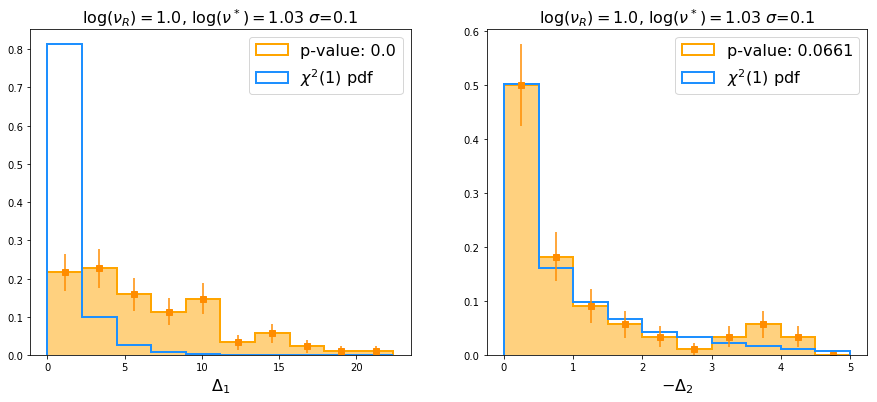

t0: dof 6, test 77.46, pval 0.0
tc: dof 6, test 5.63, pval 0.4659
t0: dof 6, test 73.88, pval 0.0
tc1: dof 6, test 14.45, pval 0.025
t0: dof 6, test 87.11, pval 0.0
tc2: dof 6, test 136.41, pval 0.0


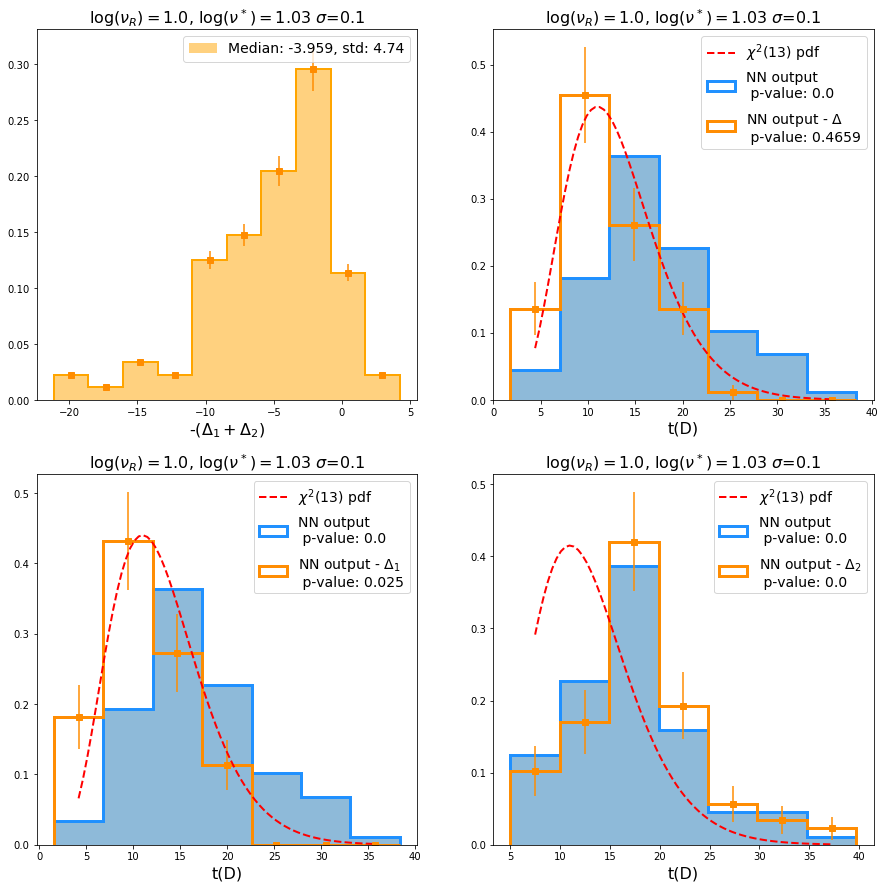

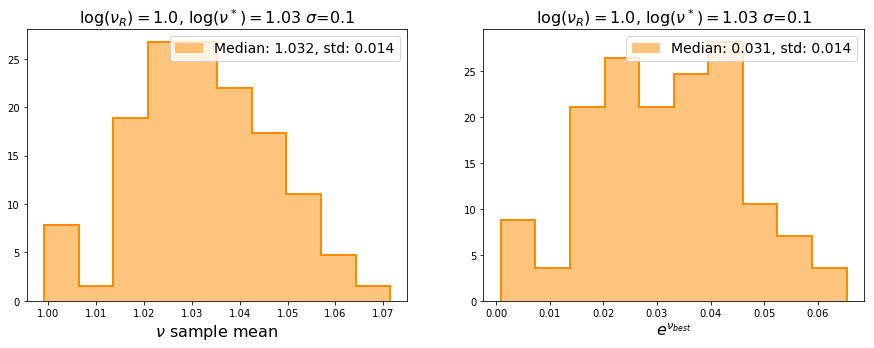

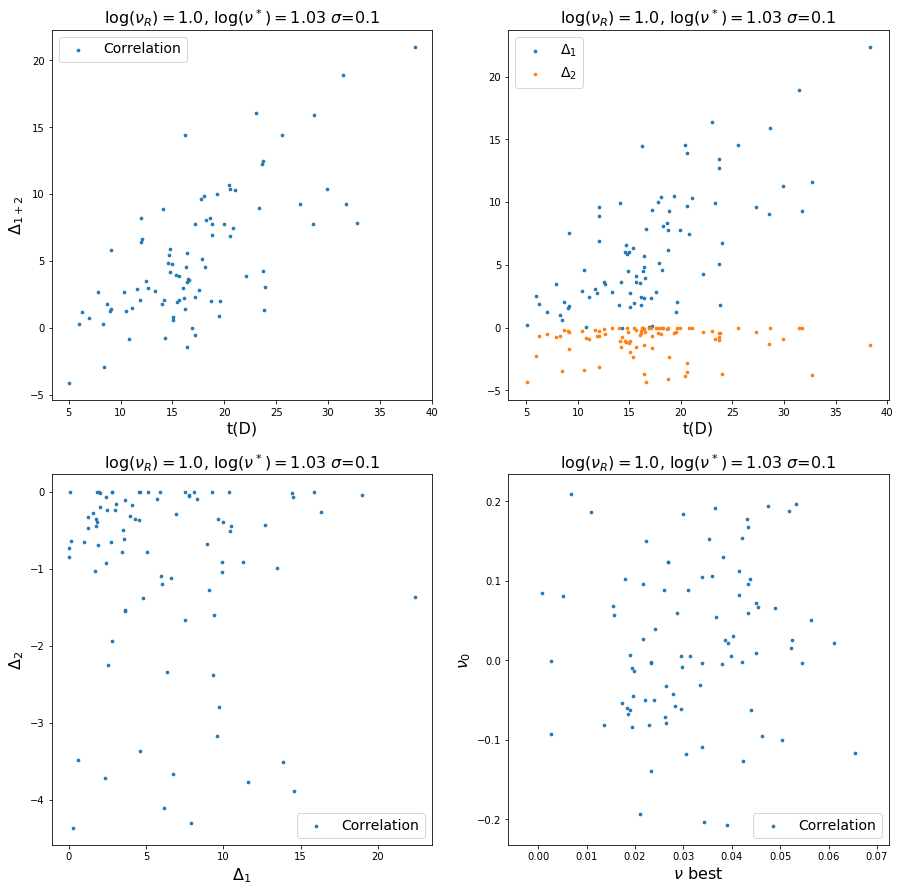

In [19]:
print('pstar:%f'%(scale_star))
print('sigma:%f'%(sigma))
pv1, pv2 = Delta_hist(Delta1, Delta2, scale_REF, scale_star, sigma, 
                      df1=1, df2=1, bins1=10, bins2=10, 
                      plot=True, verbose=True)
pv3, pv4 = t_hist(t, t_corrected, Delta, Delta1, Delta2, nubest, 
                  scale_REF, scale_star, sigma, df=13, n=7,
                  bins1=10, bins2=7, bins3=7, bins4=7, 
                  xmin2=np.min(t_corrected), xmax2=np.max(t), 
                  xmin3=np.min(t-Delta1), xmax3=np.max(t), 
                  xmin4=np.min(t), xmax4=np.max(t-Delta2),
                  plot=True, verbose=True)
nu_hist(nubest, mean, scale_REF, scale_star, sigma)
correlation_plots(t, Delta, Delta1, Delta2, nubest, nu0, scale_REF, scale_star, sigma)